In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shutil
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from torchvision import datasets, models
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score

Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 1
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 1
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0
Original: 0, Shuffled: 0


Epoch [10/10], Train Loss: 0.6101, Val Loss: 5.3904


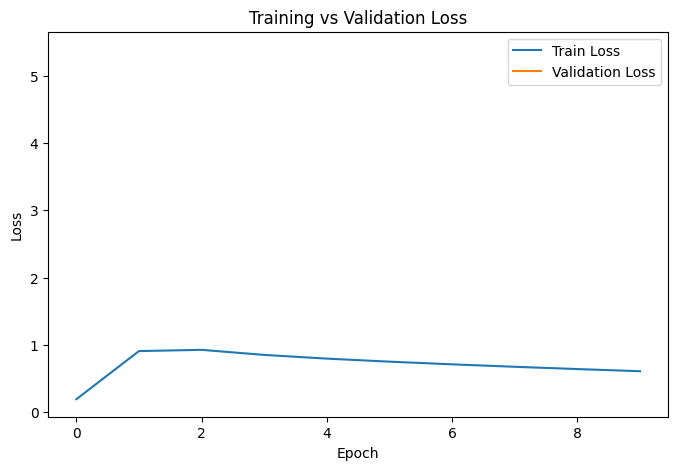

Finished Training
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

Balanced Accuracy: 0.5000
F1 Score (weighted): 0.4808


/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/software/stacks/2024-05/python-cuda/3.11.6/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

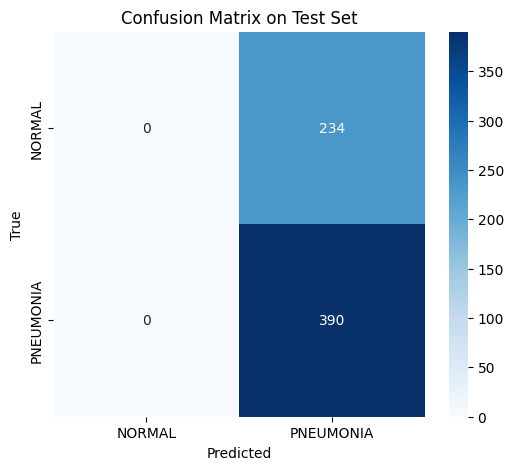

In [29]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Transformation: resize, convert to grayscale, normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Define paths to the preprocessed datasets
train_dir = './final_preprocessed_dataset/train'
val_dir = './final_preprocessed_dataset/val'
test_dir = './final_preprocessed_dataset/test'

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

np.random.seed(42) 
original_targets = train_dataset.targets.copy() 
shuffled_indices = np.random.permutation(len(train_dataset.targets))
shuffled_targets = np.array(train_dataset.targets)[shuffled_indices]

# Assign the shuffled labels back
train_dataset.targets = shuffled_targets.tolist()

for i in range(100):
    print(f"Original: {original_targets[i]}, Shuffled: {train_dataset.targets[i]}")

print("Training labels have been randomized for the data randomization test.")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze early layers (optional for fine-tuning)
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)  # Two output classes

model = resnet50.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    model.load_state_dict(torch.load('models/resnet50_xray_neumonia.pt'))

else:
    
    # Training loop
    num_epochs = 10
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = 0
    loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot Training and Validation Loss
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    print('Finished Training')
    torch.save(model.state_dict(), './models/resnet50_xray_neumonia_random_labels.pt')

# Evaluate on Test Set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Report
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# Balanced Accuracy & F1 Score
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')  # use 'macro' if you want unweighted per-class avg

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()

#### Integrated Gradients

In [ ]:
#Anna's code
import torch
import torchvision.models as models
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import torch
import torchvision.transforms as transforms
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F
import cv2

random.seed(42) 

In [ ]:
def load_model(model_path):
    try:
        # Try loading as a complete model
        model = torch.load(model_path, map_location=torch.device('cpu'))
        
        # Check if what was loaded is actually a state_dict (OrderedDict)
        if isinstance(model, dict) or isinstance(model, torch.nn.modules.module._IncompatibleKeys) or isinstance(model, collections.OrderedDict):
            print("Loaded file appears to be a state_dict, not a complete model")
            # Initialize a model to load the state_dict into
            base_model = models.resnet50(weights=None)  # Using weights=None instead of pretrained=True
            # Modify the final layer for binary classification (assuming binary)
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)  # 2 classes
            # Load the state dict
            base_model.load_state_dict(model)
            model = base_model
            print("Successfully loaded state_dict into ResNet50 model")
        else:
            print("Loaded complete model")
    except Exception as e:
        print(f"Error during initial model loading: {e}")
        try:
            # Explicitly try loading as a state_dict
            base_model = models.resnet50(weights=None)  # Using weights=None instead of pretrained=True
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)  # 2 classes
            base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            model = base_model
            print("Loaded state_dict into ResNet50 with binary classification head")
        except Exception as e:
            print(f"Error loading state_dict: {e}")
            print("Falling back to pretrained ResNet50")
            model = models.resnet50(weights='IMAGENET1K_V1')  # Using weights parameter instead of pretrained
    
    model.eval()
    return model

In [ ]:
def get_random_png_files(folder_path, n=5):
    """Get n random PNG files from the given folder"""
    all_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    
    if len(all_files) < n:
        print(f"Warning: Only {len(all_files)} PNG files found in {folder_path}")
        return [os.path.join(folder_path, f) for f in all_files]
    
    selected_files = random.sample(all_files, n)
    return [os.path.join(folder_path, f) for f in selected_files]

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  # Match your training transform
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Match your [-1,1] normalization
    ])
    
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor, image

In [ ]:
def compute_ig_overlay(ig, input_tensor, original_image_np, target_class):
    input_tensor.requires_grad = True
    baseline = torch.zeros_like(input_tensor)
    attributions = ig.attribute(input_tensor, baselines=baseline, target=target_class, n_steps=50)
    attr = attributions.squeeze().cpu().detach().numpy()
    attr = np.abs(attr)
    attr = (attr - np.min(attr)) / (np.max(attr) - np.min(attr) + 1e-8)  # Normalize
    attr_resized = np.squeeze(attr)
    heatmap = plt.cm.hot(attr_resized)[..., :3]  # RGB heatmap
    overlay = heatmap * 0.3 + original_image_np * 0.7
    overlay /= np.max(overlay)
    return overlay

In [4]:
def apply_colormap_to_cam(cam):
    # Ensure cam is 2D: [H, W]
    if cam.ndim == 3:
        cam = np.mean(cam, axis=0)  # collapse channel if needed

    # Normalize cam to [0, 255] and convert to uint8
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # [0, 1]
    cam_heatmap = np.uint8(cam * 255)  # [H, W], dtype=uint8

    # Apply OpenCV colormap
    colored_cam = cv2.applyColorMap(cam_heatmap, cv2.COLORMAP_JET)  # [H, W, 3], BGR
    colored_cam = cv2.cvtColor(colored_cam, cv2.COLOR_BGR2RGB)      # Convert to RGB

    return colored_cam / 255.0  # Normalize to [0,1] float for overlay


def compute_ig_overlay(ig, input_tensor, original_image_np, target_class):
    input_tensor = input_tensor.clone().detach().requires_grad_(True)
    baseline = torch.zeros_like(input_tensor)

    attributions = ig.attribute(input_tensor, baselines=baseline, target=target_class, n_steps=50)
    attr = attributions.squeeze().cpu().detach().numpy()  # shape: [H, W]

    # Normalize attribution map
    attr = np.abs(attr)
    attr = (attr - np.min(attr)) / (np.max(attr) - np.min(attr) + 1e-8)

    # Apply OpenCV colormap
    heatmap = apply_colormap_to_cam(attr)  # shape: [H, W, 3]

    # Make sure original_image_np is RGB
    if original_image_np.ndim == 2:
        original_image_np = np.stack([original_image_np] * 3, axis=-1)  # shape: [H, W, 3]

    overlay = heatmap * 0.3 + original_image_np * 0.7
    overlay = overlay / overlay.max()

    return overlay


In [5]:
def get_correctly_classified_images(model, healthy_folder, disease_folder, num_samples=5):
    random.seed(42)

    all_healthy_images = get_random_png_files(healthy_folder, n=20)
    all_disease_images = get_random_png_files(disease_folder, n=20)

    correctly_classified_healthy = []
    correctly_classified_disease = []

    print("Finding correctly classified healthy images...")
    for img_path in all_healthy_images:
        input_tensor, _ = preprocess_image(img_path)
        with torch.no_grad():
            pred_class = torch.argmax(model(input_tensor)).item()
        if pred_class == 0:
            correctly_classified_healthy.append(img_path)
            print(f"  Found correctly classified healthy image: {os.path.basename(img_path)}")
        if len(correctly_classified_healthy) >= num_samples:
            break

    print("Finding correctly classified disease images...")
    for img_path in all_disease_images:
        input_tensor, _ = preprocess_image(img_path)
        with torch.no_grad():
            pred_class = torch.argmax(model(input_tensor)).item()
        if pred_class == 1:
            correctly_classified_disease.append(img_path)
            print(f"  Found correctly classified disease image: {os.path.basename(img_path)}")
        if len(correctly_classified_disease) >= num_samples:
            break

    return correctly_classified_healthy[:num_samples], correctly_classified_disease[:num_samples]

def visualize_integrated_gradients(model, healthy_paths, disease_paths, save_path="ig_attribution_maps_comparison.png"):
    from captum.attr import IntegratedGradients
    fig = plt.figure(figsize=(15, 10))
    num_samples = min(len(healthy_paths), len(disease_paths))
    gs = GridSpec(2, num_samples, figure=fig)

    ig = IntegratedGradients(model)

    print("Processing healthy images...")
    for i, img_path in enumerate(healthy_paths):
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image.convert("L")) / 255.0
        # original_image_np = np.stack([original_image_np]*3, axis=-1)

        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()

        overlay = compute_ig_overlay(ig, input_tensor, original_image_np, pred_class)
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(overlay)
        ax.set_title(f"{os.path.basename(img_path)}\nPred: Healthy ({confidence:.2f})")
        ax.axis('off')

    print("Processing disease images...")
    for i, img_path in enumerate(disease_paths):
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image.convert("L")) / 255.0
        # original_image_np = np.stack([original_image_np]*3, axis=-1)

        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()

        overlay = compute_ig_overlay(ig, input_tensor, original_image_np, pred_class)
        ax = fig.add_subplot(gs[1, i])
        ax.imshow(overlay)
        ax.set_title(f"{os.path.basename(img_path)}\nPred: Disease ({confidence:.2f})")
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Integrated Gradients Attribution Maps: Correctly Classified Samples", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Visualization complete! Saved as '{save_path}'")



In [ ]:
model = load_model('./models/resnet50_xray_neumonia_random_labels.pt')

In [ ]:
# This takes 2 minutes - i just copied the results below
# healthy_paths, disease_paths = get_correctly_classified_images(model, healthy_folder, disease_folder, num_samples=5)

In [ ]:
healthy_paths = ['./final_preprocessed_dataset/test/NORMAL/image_00150.png',
 './final_preprocessed_dataset/test/NORMAL/image_00100.png',
 './final_preprocessed_dataset/test/NORMAL/image_00051.png',
 './final_preprocessed_dataset/test/NORMAL/image_00010.png',
 './final_preprocessed_dataset/test/NORMAL/image_00187.png']
disease_paths = ['./final_preprocessed_dataset/test/PNEUMONIA/image_00435.png',
 './final_preprocessed_dataset/test/PNEUMONIA/image_00496.png',
 './final_preprocessed_dataset/test/PNEUMONIA/image_00437.png',
 './final_preprocessed_dataset/test/PNEUMONIA/image_00376.png',
 './final_preprocessed_dataset/test/PNEUMONIA/image_00331.png']

In [ ]:
visualize_integrated_gradients(model, healthy_paths, disease_paths)

#### GradCAM

Using 5 predefined healthy images and 5 predefined disease images
Loaded file appears to be a state_dict, not a complete model
Successfully loaded state_dict into ResNet50 model
Processing healthy images...
  Processing image_00150.png
  Processing image_00100.png
  Processing image_00051.png
  Processing image_00010.png
  Processing image_00187.png
Processing disease images...
  Processing image_00435.png
  Processing image_00496.png
  Processing image_00437.png
  Processing image_00376.png
  Processing image_00331.png


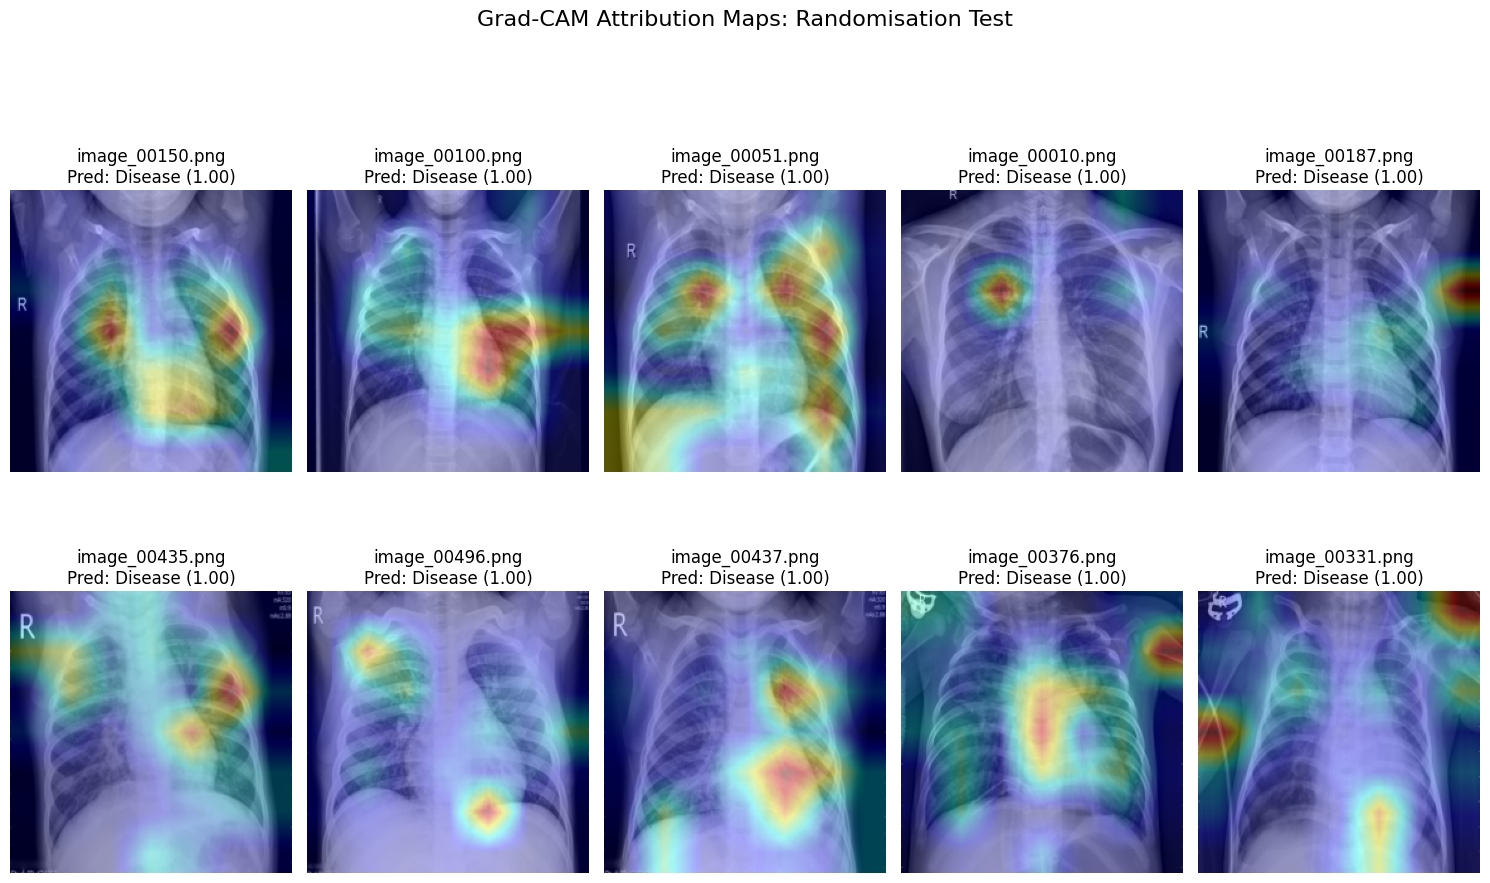

Visualization complete! Saved as 'specific_attribution_maps_comparison.png'


In [32]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import transforms, models
from matplotlib.gridspec import GridSpec
import collections

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        model_output = self.model(input_image)
        if target_class is None:
            target_class = torch.argmax(model_output)
        confidence = F.softmax(model_output, dim=1)[0, target_class].item()

        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0][target_class] = 1
        model_output.backward(gradient=one_hot_output)

        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)

        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-8)
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        return cam.squeeze().cpu().numpy(), confidence, target_class

def load_model(model_path):
    try:
        model = torch.load(model_path, map_location=torch.device('cpu'))
        if isinstance(model, dict) or isinstance(model, torch.nn.modules.module._IncompatibleKeys) or isinstance(model, collections.OrderedDict):
            print("Loaded file appears to be a state_dict, not a complete model")
            base_model = models.resnet50(weights=None)
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)
            base_model.load_state_dict(model)
            model = base_model
            print("Successfully loaded state_dict into ResNet50 model")
        else:
            print("Loaded complete model")
    except Exception as e:
        print(f"Error during initial model loading: {e}")
        try:
            base_model = models.resnet50(weights=None)
            num_features = base_model.fc.in_features
            base_model.fc = torch.nn.Linear(num_features, 2)
            base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            model = base_model
            print("Loaded state_dict into ResNet50 with binary classification head")
        except Exception as e:
            print(f"Error loading state_dict: {e}")
            print("Falling back to pretrained ResNet50")
            model = models.resnet50(weights='IMAGENET1K_V1')
    model.eval()
    return model

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)
    return input_tensor, image

def apply_colormap_to_cam(cam):
    cam_heatmap = np.uint8(255 * cam)
    colored_cam = cv2.applyColorMap(cam_heatmap, cv2.COLORMAP_JET)
    colored_cam = cv2.cvtColor(colored_cam, cv2.COLOR_BGR2RGB)
    return colored_cam

def visualize_folder_samples(model_path, num_samples=5):
    # Use predefined image paths
    healthy_images = [
        './final_preprocessed_dataset/test/NORMAL/image_00150.png',
        './final_preprocessed_dataset/test/NORMAL/image_00100.png',
        './final_preprocessed_dataset/test/NORMAL/image_00051.png',
        './final_preprocessed_dataset/test/NORMAL/image_00010.png',
        './final_preprocessed_dataset/test/NORMAL/image_00187.png'
    ]

    disease_images = [
        './final_preprocessed_dataset/test/PNEUMONIA/image_00435.png',
        './final_preprocessed_dataset/test/PNEUMONIA/image_00496.png',
        './final_preprocessed_dataset/test/PNEUMONIA/image_00437.png',
        './final_preprocessed_dataset/test/PNEUMONIA/image_00376.png',
        './final_preprocessed_dataset/test/PNEUMONIA/image_00331.png'
    ]

    print(f"Using {len(healthy_images)} predefined healthy images and {len(disease_images)} predefined disease images")

    # Load model
    model = load_model(model_path)

    # Define target layer (for ResNet)
    if hasattr(model, 'layer4'):
        target_layer = model.layer4[-1]
    else:
        print("Please specify the correct target layer for your model")
        return

    grad_cam = GradCAM(model, target_layer)

    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, min(num_samples, len(healthy_images), len(disease_images)), figure=fig)

    # Process healthy images
    print("Processing healthy images...")
    for i, img_path in enumerate(healthy_images[:num_samples]):
        print(f"  Processing {os.path.basename(img_path)}")
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image)

        with torch.no_grad():
            output = model(input_tensor)
            pred_class = torch.argmax(output).item()
            confidence = F.softmax(output, dim=1)[0, pred_class].item()

        cam, _, _ = grad_cam.generate_cam(input_tensor, target_class=pred_class)
        heatmap = apply_colormap_to_cam(cam)
        overlay = heatmap * 0.3 + original_image_np * 0.7
        overlay = overlay / np.max(overlay)

        ax = fig.add_subplot(gs[0, i])
        ax.imshow(overlay)
        class_name = "Healthy" if pred_class == 0 else "Disease"
        ax.set_title(f"{os.path.basename(img_path)}\nPred: {class_name} ({confidence:.2f})")
        ax.axis('off')

    # Process disease images
    print("Processing disease images...")
    for i, img_path in enumerate(disease_images[:num_samples]):
        print(f"  Processing {os.path.basename(img_path)}")
        input_tensor, original_image = preprocess_image(img_path)
        original_image_np = np.array(original_image)

        with torch.no_grad():
            output = model(input_tensor)
            pred_class = torch.argmax(output).item()
            confidence = F.softmax(output, dim=1)[0, pred_class].item()

        cam, _, _ = grad_cam.generate_cam(input_tensor, target_class=pred_class)
        heatmap = apply_colormap_to_cam(cam)
        overlay = heatmap * 0.3 + original_image_np * 0.7
        overlay = overlay / np.max(overlay)

        ax = fig.add_subplot(gs[1, i])
        ax.imshow(overlay)
        class_name = "Healthy" if pred_class == 0 else "Disease"
        ax.set_title(f"{os.path.basename(img_path)}\nPred: {class_name} ({confidence:.2f})")
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Grad-CAM Attribution Maps: Randomisation Test", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.savefig("randomised_attribution_maps_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("Visualization complete! Saved as 'specific_attribution_maps_comparison.png'")

# Example usage
def main():
    model_path = "./models/resnet50_xray_neumonia_random_labels.pt"
    visualize_folder_samples(model_path, num_samples=5)

if __name__ == "__main__":
    main()